**Authors**: Carayon Chloé - Taillieu Victor

**Date**: 08/12/2020

---
# LAB3 Machine Learning: Logistic Regression
---

## Introduction

In this third lab, we have to build from scratch a logistic regression model and then compare its results to the one  from
Scikit-Learn library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## 1. Data understanding

### 1.1. Loading and exploring data

Let's load and take a look at the loan_prediction dataset:

In [2]:
df = pd.read_csv("data/loan_prediction.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:
df.describe(include="object")

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001497,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


We have 13 columns:

* Loan_ID: string to represent the ID of the loan 
* Gender: gender of the person, male or female 
* Married: marital status of the person, yes or no 
* Dependents: number of children, 0, 1, 2 or 3+
* Education: graduated or not
* Self_Employed: if the person is self employed or not, yes or no
* ApplicantIncome: the applicant income
* CoapplicantIncome: the coapplicant income
* LoanAmount: the loan amount in thousand of $
* Loan_Amount_Term: the term loan amount for each month
* Credit_History: the credit history, if the person already had a credit or not, 1 or 0
* Property_Area: the area, urban, semi urban or rural
* Loan_Status: loan approved, yes or no

As the variable to predict is the loan status, we have to implement a model to choose either yes or no.  
So it is a **binary** logistic regression and a **supervised** machine learning problem.

We can briefly look at the plot below to see the proportion of loan status.

Nb Yes: 422
Nb No: 192


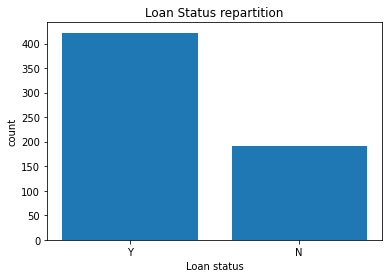

In [4]:
not_loan = df[df.Loan_Status == 'N'].count().Loan_Status
loan = df[df.Loan_Status == 'Y'].count().Loan_Status

print("Nb Yes:", loan)
print("Nb No:", not_loan)

plt.bar(["Y", "N"], [loan, not_loan])
plt.title("Loan Status repartition")
plt.xlabel("Loan status")
plt.ylabel("count")
plt.show()

It appears that people are twice as likely to obtain a loan regarding this dataset.
So this dataset is **unbalanced**.  
The loan status depends on many criteria, as we have 12 different features.  
In order to provide the best logistic regression to fit the model, we need to review the dataset and manage several parameters.

### 1.2. Handling missing values

Let's check if there are missing values:

In [5]:
print("Number of missing values:")
print(df.isnull().sum())

Number of missing values:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


We obtain 149 missing values in 7 different columns, we have to handle them in order to perform the logistic regression. 
We need to fill or drop them depending on the analysis we will make.

#### 1.2.1. Binary and categorical features

In order to handle missing values, we can look at the different features and their impact on the loan status.

##### 1.2.1.1. Gender feature

For gender, we obtain the following results:

Nb Male: 489
Nb Female: 112
Nb nan: 13


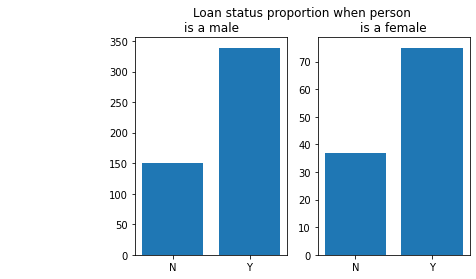

In [6]:
print("Nb Male:", df[df.Gender == "Male"].shape[0])
print("Nb Female:", df[df.Gender == "Female"].shape[0])
print("Nb nan:", df[df.Gender.isnull()].shape[0])

plt.subplot(121)
plt.bar(["N", "Y"], df[df.Gender == 'Male'].groupby(df.Loan_Status).count().Gender)
plt.title("                                                Loan status proportion when person \nis a male")

plt.subplot(122)
plt.bar(["N", "Y"], df[df.Gender == "Female"].groupby(df.Loan_Status).count().Gender)
plt.title("is a female")
plt.show()

Looking at the plots, we clearly see that the gender does not seem to affect the loan status, as there is a
similar ratio of loan status distribution regardless the gender.
So we can replace the missing values by the most common one, the male gender.

In [7]:
df.Gender.fillna("Male", inplace=True)

##### 1.2.1.2. Married feature

Let's take a look at the rows of the 3 missing values:

In [8]:
print("Nb married:", df[df.Married == "Yes"].shape[0])
print("Nb not married:", df[df.Married == "No"].shape[0])
print("Nb nan:", df[df.Married.isnull()].shape[0])
df[df.Married.isnull()]

Nb married: 398
Nb not married: 213
Nb nan: 3


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


We only have 3 missing values for the Married feature. In addition, for thoses values, the dependents feature is also null.  
So we can drop those 3 rows, it is not a big loss of information.

In [9]:
df.dropna(subset=["Married"], inplace=True)

##### 1.2.1.3. Dependents feature

For dependents feature, we have 4 possible values and we obtain the following plots:

Nb 0: 345
Nb 1: 102
Nb 2: 101
Nb 3+: 51
Nb nan: 12


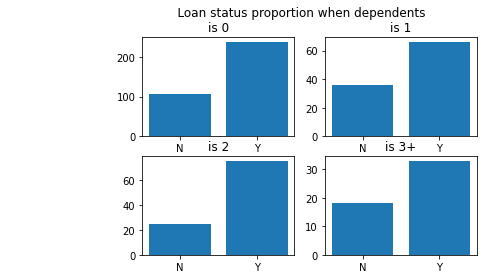

In [10]:
print("Nb 0:", df[df.Dependents == "0"].shape[0])
print("Nb 1:", df[df.Dependents == "1"].shape[0])
print("Nb 2:", df[df.Dependents == "2"].shape[0])
print("Nb 3+:", df[df.Dependents == "3+"].shape[0])
print("Nb nan:", df[df.Dependents.isnull()].shape[0])

plt.subplot(221)
plt.bar(["N", "Y"], df[df.Dependents == "0"].groupby(df.Loan_Status).count().Dependents)
plt.title("                                            Loan status proportion when dependents \nis 0")

plt.subplot(222)
plt.bar(["N", "Y"], df[df.Dependents == "1"].groupby(df.Loan_Status).count().Dependents)
plt.title("is 1")

plt.subplot(223)
plt.bar(["N", "Y"], df[df.Dependents == '2'].groupby(df.Loan_Status).count().Dependents)
plt.title("is 2")

plt.subplot(224)
plt.bar(["N", "Y"], df[df.Dependents == "3+"].groupby(df.Loan_Status).count().Dependents)
plt.title("is 3+")
plt.show()

On those 4 plots, the value yes for loan status is dominant.  
Even if the ratio of yes/no is not identical for all of them, we see that the dependents doesn't seem to affect importantly the loan decision.  
So we can change the missing values by the most predominant category: 0.

In [11]:
df.Dependents.fillna("0", inplace=True)

##### 1.2.1.4. Self employed feature

We can look at the missing values and plots of self employed:

Nb self-employed: 82
Nb not self-employed: 497
Nb nan: 32


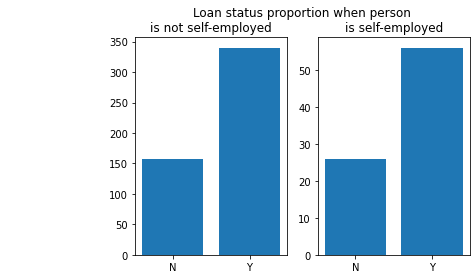

In [12]:
print("Nb self-employed:", df[df.Self_Employed == "Yes"].shape[0])
print("Nb not self-employed:", df[df.Self_Employed == "No"].shape[0])
print("Nb nan:", df[df.Self_Employed.isnull()].shape[0])

plt.subplot(121)
plt.bar(["N", "Y"], df[df.Self_Employed == 'No'].groupby(df.Loan_Status).count().Self_Employed)
plt.title("                                                Loan status proportion when person \nis not self-employed")

plt.subplot(122)
plt.bar(["N", "Y"], df[df.Self_Employed == "Yes"].groupby(df.Loan_Status).count().Self_Employed)
plt.title("is self-employed")
plt.show()

We clearly see that the self-employed feature does not seem to affect the loan status, as there is a similar 
ratio of loan status distribution regardless the employement.  
So we can replace the missing values by the most common one, not self-employed.

In [13]:
df.Self_Employed.fillna("No", inplace=True)

##### 1.2.1.5. Credit history feature

The credit history feature is the feature with the most missing values. We have to be carefull by looking at the repartition and 
the correlation with the loan status.

Nb Yes: 472
Nb No: 89
Nb nan: 50


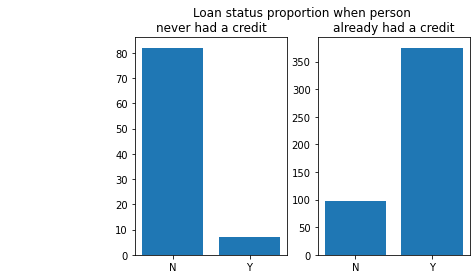

In [14]:
print("Nb Yes:", df[df.Credit_History == 1].shape[0])
print("Nb No:", df[df.Credit_History == 0].shape[0])
print("Nb nan:", df[df.Credit_History.isnull()].shape[0])

plt.subplot(121)
plt.bar(["N", "Y"], df[df.Credit_History == 0].groupby(df.Loan_Status).count().Credit_History)
plt.title("                                                Loan status proportion when person \nnever had a credit")

plt.subplot(122)
plt.bar(["N", "Y"], df[df.Credit_History == 1].groupby(df.Loan_Status).count().Credit_History)
plt.title("\nalready had a credit")
plt.show()

By looking at the plots, we clearly see that when a person alreadly had a credit, she or he will more easily 
obtain a loan and on the contrary, if the person never had a credit, she or he will hardly obtain a loan.
So we decided to replace the missing values depending on the loan status:
if the loan status is Yes, the credit history will be 1, whereas if the loan status is No, the credit history will be 0.

In [15]:
df.Credit_History.fillna(df.Loan_Status, inplace=True)
df.Credit_History.replace(["Y", "N"], [1, 0], inplace=True)

Now, we can work on the numerical features.

#### 1.2.2. Numerical features 

#####  1.2.2.1. Loan amount

For loan amount, we have 22 missing values, we can look at the histogram to select the best way to handle those missing values:

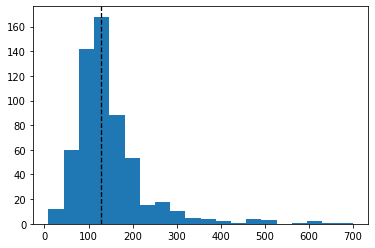

Median: 127.5


In [16]:
plt.hist(df.LoanAmount, bins=20)
plt.axvline(df.LoanAmount.median(), color='k', linestyle='dashed', linewidth=1.3)
plt.show()
print("Median:",df.LoanAmount.median())

As we can see, the distribution is centered around the median so we can replace the missing values by 
the median.  
We do not take the mean because we remark some outliers with high values for the loan amount.

In [17]:
df.LoanAmount.fillna(df.LoanAmount.median(), inplace=True)

##### 1.2.2.2. Loan amount term

For loan amount term, we have 14 missing values, looking at the histogram to select the best way to handle those missing values, we obtain:

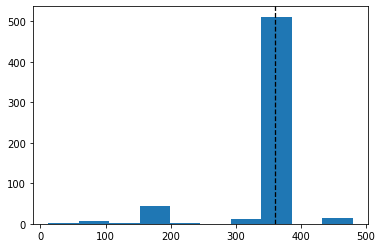

Mode: 360.0


In [18]:
plt.hist(df.Loan_Amount_Term, bins=10)
plt.axvline(df.Loan_Amount_Term.mode()[0], color='k', linestyle='dashed', linewidth=1.3)
plt.show()
print("Mode:", df.Loan_Amount_Term.mode()[0])

Here, the predominant value is clearly 360 and the others appear really rarely.  
We choose to replace the missing values by the mode as it represents the most frequent value.

In [19]:
df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.mode()[0], inplace=True)

As we handled missing values, we can now build our logistic regression from scratch.

## 2. Preprocessing

Some variables can not be properly used for our logistic regression, we have to handle those string variables by transforming them into binary or numerical ones.

In [20]:
df.replace(["Female", "Male"], [0, 1], inplace=True)
df.replace(["No", "Yes"], [0, 1], inplace=True)
df.replace(["Not Graduate", "Graduate"], [0, 1], inplace=True)
df.replace(["0", "1", "2", "3+"], [0, 1, 2, 3], inplace=True)
df.replace(["Rural", "Semiurban", "Urban"], [0, 1, 2], inplace=True)
df.replace(["N", "Y"], [0, 1], inplace=True)

We also decided to drop one of the features, Loan_ID which is an unique identifier and is useless to make predictions.

In [21]:
df.drop("Loan_ID", axis=1, inplace=True)

We obtain the following dataframe:

In [22]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,1,0,5849,0.0,127.5,360.0,1.0,2,1
1,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,1,0,2900,0.0,71.0,360.0,1.0,0,1
610,1,1,3,1,0,4106,0.0,40.0,180.0,1.0,0,1
611,1,1,1,1,0,8072,240.0,253.0,360.0,1.0,2,1
612,1,1,2,1,0,7583,0.0,187.0,360.0,1.0,2,1


After cleaning the dataset, let's build the logistic regression model from scratch. 

## 3. Build the logistic model from scratch

Firstly we have to implement the following functions to build our model:

* normalizeFeatures(params)
* sigmoid(params)
* costFunction(params)
* gradientDescent(params)

The parameters we use are:

- $X$: matrix of observations (m, n + 1)
- $y$: vector of labels (m, 1)
- $w$: vector of weights of the model (n + 1, 1)
- $m$: number of observations
- $n$: number of features

### 3.1. Normalization 

Before going through the logistic regression, we have to normalize the features.
They have different range and the ones with the highest values could easily take precedence over the others.
That is why we have to rescale all the variables and make them close to 0.

We decided to use min-max normalization:  
$X_{norm} = \frac{X - min(X)}{max(X)-min(X)}$

In [23]:
def normalizeFeatures(X, scaling=None):
    if scaling is None:
        scaling = list(zip(X.min(), X.max()))
    minmax = list(zip(*scaling))
    min, max = np.array(minmax[0]), np.array(minmax[1])
    # min-max normalization
    X = np.asmatrix((X - min) / (max - min))

    return np.insert(X, 0, 1, axis=1), scaling

After normalizing the data, we have to build the gradient descent.  
Unlike the linear regression, to build the gradient descent of the logistic regression, we need to implement the **sigmoid** function.

### 3.2. Sigmoid 

The sigmoid function allows us to map predicted values to **probabilities**, which means values between 0 and 1.  

$S(z) = \frac{1}{1 + e^{-z}}, z=Xw$

which gives:

$S(Xw) = \frac{1}{1 + e^{-Xw}}$

In [24]:
def sigmoid(X, w):
    return 1 / (1 + np.exp(-X * w))

### 3.3. Cost function

The cost function of the logistic regression uses the sigmoid function presented above. 
Depending on the result of the sigmoid function, we have to do two different calculations.  

Its formula is 
$J(w) = \frac{1}{m} \sum_{i=1}^{m} Cost(h_w(x^{(i)}),y^{(i)})$  

with 
$\left\{\begin{matrix}
 Cost(h_w(x),y) = -log(h_w(x)) & if & y = 1 \\ 
 Cost(h_w(x),y) = -log(1- h_w(x)) & if & y = 0 
\end{matrix}\right.$

And $h_w(x^{(i)})$ the sigmoid function. 

Using the log makes easier the calculation of the gradient and minimize cost as depending on $y$, 0 or 1 
it respectivelly decreases or increases.

Combined and using linear algebra, we obtain:
$J = \frac{-1}{m} (y^Tlog(h_w(x^{(i)})) +(1-y^T)log(1- h_w(x^{(i)})))$

Each time, depending on the value of $y$ (0 or 1), it will cancel the other part of the equation ($y$ or $1-y$). 

In [25]:
def costFunction(X, y, w, m):
    sig = sigmoid(X, w)
    return float(-1 / m * (y.T * np.log(sig) + (1 - y.T) * np.log(1 - sig)))

### 3.4. Gradient descent 

The gradient descent is used to minimize the cost.

We repeat the following formula until convergence:

$w_k = w_k - \frac{\alpha }{m} \sum_{i=1}^{m} (h_w(x^{(i)})- y^{(i)})x_k^{(i)}$

$w = w - \frac{\alpha }{m} (X^T.(h_w(X^{(i)}) - y)$

We reused the gradient descent built in the first lab, except that the formula of $h_w(x)$ is different.

We use a while loop and stop when the difference between the previous and actual cost function value is 
less than the threshold value or when the number of iterations is equal to iter.  
At each iteration, we update the list of cost function values, the gradient and $w$.  
When the value of the cost function increases, it means that the learning rate is too high and we have to lower it.   
That is why we add the parameter autoAlpha in order to auto-tune (by dividing by 1.1) the value of $\alpha$ if we want to.  
Finally, we plot the values of the cost function through the iterations to evaluate the convergence of the algorithm.


Unlike the linear regression, for the logistic one, we have to take a **very small** $\alpha$.


In [26]:
def gradientDescent(X, y, m, n, alpha=0.03, threshold=1e-3, iter=1000, autoAlpha=True):
    i = 0
    J = []
    w = np.matrix([[1] for i in range(n + 1)])

    while True:
        i += 1
        J.append(costFunction(X, y, w, m))

        grad = X.T * (sigmoid(X, w) - y)
        w = w - alpha * grad

        if len(J) > 1:
            if autoAlpha and J[-1] > J[-2]:
                alpha /= 1.1

            if abs(J[-1] - J[-2]) < threshold or i == iter:
                break

    # plot cost function values
    plt.plot(np.log(J))
    plt.title("Value of the cost function over iterations")
    plt.xlabel("iteration")
    plt.ylabel("log of cost function value")
    plt.show()

    return w

### 3.5. Applying the gradient descent algorithm to the dataset

Using the functions implemented above, we can build our logistic regression.

Thanks to the exploration part, we understand that Gender, Married, Dependents, Education, Self_Employed,
ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History and Property_Area are our features
and represent the $X$ matrix and Loan_Status corresponds to the label and is the $y$ vector.

As the lab on linear regression, we split the data in train and test sets to do the logistic regression.
We will train our model on X_train and y_train and then test it on X_test and y_test.   

Firstly, we normalize X_train, and use its scaling values to normalize X_test.

In [27]:
X = df.drop("Loan_Status", axis=1)
y = df[["Loan_Status"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

m, n = X_train.shape
X_train, scaling = normalizeFeatures(X_train)
X_test = normalizeFeatures(X_test, scaling)[0]

y_train = np.asmatrix(y_train)
y_test = np.asmatrix(y_test)

We can now test our $GradientDescent$, let's test it with a very small value of $\alpha$, 0.003.

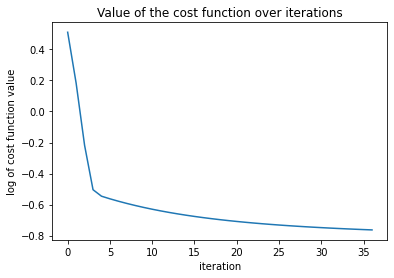

matrix([[-0.94693196],
        [-0.38118466],
        [ 0.18482454],
        [ 0.18029315],
        [ 0.20555318],
        [ 0.40319965],
        [ 0.80083277],
        [ 0.87249866],
        [ 0.40429519],
        [-0.41012068],
        [ 2.32799113],
        [ 0.04386909]])

In [28]:
coeffs = gradientDescent(X_train, y_train, m, n, alpha=0.003)
coeffs

We obtain the above plot. The convergence is very slow and the log of the $CostFunction$ is 
around -0,8.

Let's change some **hyperparameters**: increase the number of iterations to $1e4$ and threshold to $1e-9$. 

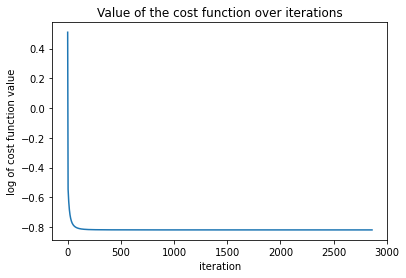

matrix([[-2.82598959],
        [-0.07721819],
        [ 0.45676453],
        [ 0.22917433],
        [ 0.63103143],
        [ 0.06463871],
        [ 0.7269864 ],
        [ 0.75345777],
        [-0.30125548],
        [-0.59108348],
        [ 3.85793586],
        [ 0.16918771]])

In [29]:
coeffs = gradientDescent(X_train, y_train, m, n, alpha=0.003, threshold=1e-9, iter=1e4)
coeffs

The convergence is better. 
But in order to verify the truthfulness of our logistic regression, we can compare it to the one from Scikit-Learn.

## 4. Compare to Scikit-Learn 

### 4.1. Functions to manage scores 

To compare the accuracy of our logistic regression from scratch to the one from Scikit-Learn, we implement four functions:
* accuracy(params)
* precision(params)
* recall(params)
* f1(params)

We use them as indicators to see if the model fits well to the data.

Those functions use the rounded of the sigmoid function and the confusion matrix, that is why, we decided to implement them in two functions.

#### 4.1.1 Predict function and confusion matrix

##### 4.1.1.1. Predict function 

To have the rounded value of the sigmoid function, we just need to use round.  
By doing that, our values are splited in two categories, the values closer to 0 and the ones closer to 1, changed respectively to 0 and 1.

In [30]:
def predict(X_pred, w):
    return sigmoid(X_pred, w).round()

##### 4.1.1.2. Confusion matrix 

The confusion matrix, is a performance measurement, which measures the quality of a model.
It is a table with 4 combinations of predicted and actual values:
* True Negative (TN)
* False Positve (FP)
* False Negative (FN)
* True Positive (TP)

It gives us:

|                 | Predicted  NO | Predicted YES |
|-----------------|:-------------:|:-------------:|
| **Actual  NO**  |       TN      |       FP      |
| **Actual  YES** |       FN      |       TP      |

To build it, we compare $y$ to the predictions from predict function.

In [31]:
def confusion(X, y, w):
    y_pred = predict(X, w)
    TN = int((1 - y_pred[y == 0]).sum())
    FP = int(y_pred[y == 0].sum())
    FN = int((1 - y_pred[y == 1]).sum())
    TP = int(y_pred[y == 1].sum())

    return np.matrix([[TN, FP], [FN, TP]])

We can use the confusion matrix in order to compute accuracy, precision and recall. 

#### 4.1.2. Accuracy

The accuracy is the proportion of correct predictions over total predictions.   
It is mostly used when all the classes are equally important.

$Accuracy = \tfrac{TN + TP}{TN + TP + FN + FP}$

We can use two implementations to compute the accuracy, one by computing the mean of our correct predictions and the other
using the confusion matrix for the calculation.

In [32]:
def accuracy(X, y, w):
    return (y == predict(X, w)).mean()

def accuracy2(X, y, w):
    matrix = confusion(X, y, w)
    return ((matrix[0, 0] + matrix[1, 1]) / (matrix[0, 0] + matrix[0, 1] + matrix[1, 0] + matrix[1, 1]))

But the accuracy is not always the best measurement to insure that a model fits the data.
If we have unbalanced dataset, it won't be representive.  
We have to take a look at other measurements.

#### 4.1.3. Precision

The precision computes the proportion of correct positive predictions over all positively predicted ones (TP and FP).  
It is useful when the cost of FP is high.

$Precision = \tfrac{TP}{TP+FP}$

We use the confusion matrix to compute it.

In [33]:
def precision(X, y, w):
    matrix = confusion(X, y, w)
    return matrix[1, 1] / (matrix[1, 1] + matrix[0, 1])

#### 4.1.4. Recall

The recall computes the proportion of correct positive predictions over the number of actual positives ones (TP and FN).   
In fact, it is used to see how much we have correctly predicted the positive class.  
It is useful when the cost of FN is high.

$Recall = \tfrac{TP}{TP+FN}$

We use the confusion matrix to compute it.

In [34]:
def recall(X, y, w):
    matrix = confusion(X, y, w)
    return matrix[1, 1] / (matrix[1, 1] + matrix[1, 0])

#### 4.1.5. f1-score

The f1-score is used to compare two models. It is a balanced mean between precision and recall.   

$f1 = 2.\tfrac{Precision.Recall}{Precision+Recall}$


In [35]:
def f1(X, y, w):
    pre = precision(X, y, w)
    rec = recall(X, y, w)
    return 2 * pre * rec / (pre + rec)

### 4.2. Compare to Scikit-Learn 

#### 4.2.1.  Build a new logistic regresion model with Scikit-Learn

Let's build a logistic regression using the $LogisticRegression$ class from Scikit-Learn library.

In [36]:
reg = linear_model.LogisticRegression()
reg.fit(X_train, y_train)
coeffs_sklearn = reg.coef_
y_pred = reg.predict(X_test)
coeffs_sklearn[0, 0] = reg.intercept_
coeffs_sklearn = coeffs_sklearn.T

c:\python\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


#### 4.2.2. Compare logistic models

We can now compare those two logistic regression models.

In [37]:
print("Scikit-Learn")
print(coeffs_sklearn)
print("\nConfusion matrix:\n", confusion(X_train, y_train, coeffs_sklearn))
print("Accuracy:", accuracy(X_train, y_train, coeffs_sklearn))
print("Precision:", precision(X_train, y_train, coeffs_sklearn))
print("Recall:", recall(X_train, y_train, coeffs_sklearn))
print("F1-score:", f1(X_train, y_train, coeffs_sklearn))

print("\n\nLogistic model")
print(coeffs)
print("\nConfusion matrix:\n", confusion(X_train, y_train, coeffs))
print("Accuracy:", accuracy(X_train, y_train, coeffs))
print("Precision:", precision(X_train, y_train, coeffs))
print("Recall:", recall(X_train, y_train, coeffs))
print("F1-score:", f1(X_train, y_train, coeffs))

Scikit-Learn
[[-2.44816876]
 [-0.06222258]
 [ 0.4205428 ]
 [ 0.17793724]
 [ 0.57452944]
 [ 0.08444219]
 [ 0.11094913]
 [ 0.09099877]
 [-0.06057049]
 [-0.33916367]
 [ 3.32797682]
 [ 0.15472534]]

Confusion matrix:
 [[ 71  76]
 [  7 334]]
Accuracy: 0.8299180327868853
Precision: 0.8146341463414634
Recall: 0.9794721407624634
F1-score: 0.8894806924101198


Logistic model
[[-2.82598959]
 [-0.07721819]
 [ 0.45676453]
 [ 0.22917433]
 [ 0.63103143]
 [ 0.06463871]
 [ 0.7269864 ]
 [ 0.75345777]
 [-0.30125548]
 [-0.59108348]
 [ 3.85793586]
 [ 0.16918771]]

Confusion matrix:
 [[ 71  76]
 [  7 334]]
Accuracy: 0.8299180327868853
Precision: 0.8146341463414634
Recall: 0.9794721407624634
F1-score: 0.8894806924101198


Looking at the confusion matrix and the scores of the two models, we see that they are identical even if we obtain different values for their coefficients.   
It can be explained by the fact that we do not have many observations and the two models distinct clearly the two categories.

Finally, as the dataset is unbalanced, it is better to focus on the result of f1-score. We obtain a good f1-score around 0.89,
which prooves that the logistic model fits well the data. 

Moreover, we can briefly compare the results of our from scratch score functions to the ones from Scikit-Learn on the test set:

In [38]:
print("\nConfusion matrix:\nScratch:\n", confusion(X_test, y_test, coeffs_sklearn))
print("Scikit-Learn:\n", confusion_matrix(y_test, y_pred))

print("\nCompare our score functions to the ones of Scikit-Learn:")
print("Accuracy\nScratch:", accuracy(X_test, y_test, coeffs_sklearn))
print("Scikit-Learn:", accuracy_score(y_test, y_pred))

print("\nPrecision\nScratch:", precision(X_test, y_test, coeffs_sklearn))
print("Scikit-Learn:", precision_score(y_test, y_pred))

print("\nRecall\nScratch:", recall(X_test, y_test, coeffs_sklearn))
print("Scikit-Learn:", recall_score(y_test, y_pred))

print("\nF1-score\nScratch:", f1(X_test, y_test, coeffs_sklearn))
print("Scikit-Learn:", f1_score(y_test, y_pred))


Confusion matrix:
Scratch:
 [[24 21]
 [ 0 78]]
Scikit-Learn:
 [[24 21]
 [ 0 78]]

Compare our score functions to the ones of Scikit-Learn:
Accuracy
Scratch: 0.8292682926829268
Scikit-Learn: 0.8292682926829268

Precision
Scratch: 0.7878787878787878
Scikit-Learn: 0.7878787878787878

Recall
Scratch: 1.0
Scikit-Learn: 1.0

F1-score
Scratch: 0.8813559322033898
Scikit-Learn: 0.8813559322033898


We clearly see that we obtain identical results for from scratch functions and Scikit-Learn ones. 

And compared to the previous results on the train set, we remark that accuracy, precision and 
f1-score of the test set are smaller than train ones (which makes sense).  
However, the recall of the test set is perfect (1) compared to the one of the train test.  
This can be explained by the fact that, as the dataset is unbalanced, our model tends to over-predicts positives at the expense of negatives.  
As a result, there is no false negative for the test set but a higher rate of false positive (therefore a lower precision).

#### 4.2.3. Plot of the predicted probability

Let's plot the predicted probabilities of train and test values:

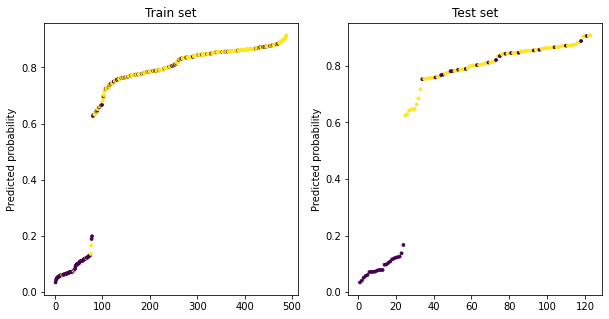

In [39]:
plt.subplots(1,2,figsize=(10,5))

plt.subplot(121)
probs = np.array(sigmoid(X_train, coeffs).T)[0].tolist()
labels = np.array(y_train.T)[0].tolist()
probs, labels = zip(*sorted(zip(probs, labels)))
indices = [i + 1 for i in range(len(probs))]
plt.scatter(indices, probs, s = 30, marker='.', c=labels)
plt.title("Train set")
plt.ylabel("Predicted probability")

plt.subplot(122)
probs = np.array(sigmoid(X_test, coeffs).T)[0].tolist()
labels = np.array(y_test.T)[0].tolist()
probs, labels = zip(*sorted(zip(probs, labels)))
indices = [i + 1 for i in range(len(probs))]
plt.scatter(indices, probs, s = 30, marker='.', c=labels)
plt.title("Test set")
plt.ylabel("Predicted probability")
plt.show()

We represented the actual positive values in yellow and actual negative ones in purple.  
Most of the time, the model predict well the loan status. 
But it clearly appears that test set encountered more false positives than the train one.  
Those plots confirm what we saw in the visualisation part, the dataset is very unbalanced, as there are more loan status at 1 (yes), than at 0 (no). 
We could take more data in order to balance it. 

## Conclusion

Thanks to our model, we can now predict the outcome of a loan demand depending on the applicants' information with a good confidence.  
This third lab allowed us to familiarize with the implementation of a logistic regression from scratch and use the one 
from Scikit-Learn. 
We build functions based on the confusion matrix to compare them and it appears that both regressions give identical results.

In order to improve our predictions, we tried to dummy some variables but unfortunately, it only slightly changes the coefficients of the model without 
affecting the confusion matrix and the scores. 
We could have handled differently missing values by dropping more of them or coupling K-nearest neighbors. But those
methods could have lead to incorrect or insufficient data, that is why we decided to only drop three rows were there were two categorical missing values.

As the dataset is unbalanced, in order to obtain more accurate results, we should try to use our implementation with a more balanced dataset with more observations.  
Finally, as we may reuse it, once again we decided to instance our implementation in a class. As we alrealdy implemented linear regression, we decided to create
a parent class called $Regression$ and add $LinearRegression$ and $LogisticRegression$ as its children.
